<a href="https://colab.research.google.com/github/freida20git/SubjectiveQA-Rater/blob/main/notebooks/CrossAttention_roberta_QArater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets evaluate

In [6]:
# Imports and Dataset Preparation
import torch
from torch import nn
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load dataset
#df = pd.read_csv('/content/drive/MyDrive/QArater/data/filtered_data.csv').fillna("") #/content/drive/MyDrive/QArater/data /filtered_data.csv
df = pd.read_csv('/content/filtered_data.csv').fillna("")


In [7]:
df.columns

Index(['qa_id', 'question_title', 'question_body', 'answer', 'category',
       'host', 'question_asker_intent_understanding', 'question_body_critical',
       'question_conversational', 'question_expect_short_answer',
       'question_fact_seeking', 'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written', 'answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
   

In [8]:
df.shape

(6079, 36)

In [ ]:
NO question_asker_intent_understanding
NO question_body_critical
NO question_type_spelling
NO question_expect_short_answer
NO question_fact_seeking
NO question_has_commonly_accepted_answer
NO question_multi_intent
NO question_not_really_a_question
NO question_type_compare
NO question_type_consequence
NO question_type_definition
NO question_type_entity

question_conversational

question_opinion_seeking

Q_INTEREST question_interestingness_others,  question_interestingness_self

QA_ISTRUCTIONS question_type_instructions, answer_type_instructions

QA_PROCEDURE question_type_procedure, answer_type_procedure

QA_REASON_EXP question_type_reason_explanation, answer_type_reason_explanation

ANSWERS_QUESTION answer_satisfaction , answer_relevance , answer_helpful

QUESTION_QUALITY question_well_written

ANSWER_QUALITY answer_level_of_information , answer_plausible  , answer_well_written




In [ ]:
!pip install transformers datasets scikit-learn pandas torch

In [9]:
df=df.drop(columns=['qa_id', 'host'])
df.head()

,question_title,question_body,answer,category,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",LIFE_ARTS,1.000000,0.333333,0.000000,0.0,0.0,0.0,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,CULTURE,1.000000,1.000000,0.000000,0.5,1.0,1.0,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,SCIENCE,0.888889,0.666667,0.000000,1.0,1.0,1.0,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",CULTURE,0.888889,0.666667,0.666667,1.0,1.0,1.0,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,1.000000,0.666667,0.000000,1.0,1.0,1.0,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [10]:
import pandas as pd

# Define groups
groups = {
    "question_conversational": ["question_conversational"],
    "question_opinion_seeking": ["question_opinion_seeking"],
    "Q_INTEREST": ["question_interestingness_others", "question_interestingness_self"],
    "QA_INSTRUCTIONS": ["question_type_instructions", "answer_type_instructions"],
    "QA_PROCEDURE": ["question_type_procedure", "answer_type_procedure"],
    "QA_REASON_EXP": ["question_type_reason_explanation", "answer_type_reason_explanation"],
    "ANSWERS_QUESTION": ["answer_satisfaction", "answer_relevance", "answer_helpful"],
    "QUESTION_QUALITY": ["question_well_written"],
    "ANSWER_QUALITY": ["answer_level_of_information", "answer_plausible", "answer_well_written"]
}

# Compute mean for each group
for group_name, metrics in groups.items():
    df[group_name] = df[metrics].mean(axis=1)

# Remove unnecessary columns
irrelevant = [
    "question_asker_intent_understanding", "question_body_critical", "question_type_spelling",
    "question_expect_short_answer", "question_fact_seeking", "question_has_commonly_accepted_answer",
    "question_multi_intent", "question_not_really_a_question", "question_type_compare",
    "question_type_consequence", "question_type_definition", "question_type_entity", "question_type_choice"]

# List of all original metric columns to drop
to_drop = irrelevant + sum(groups.values(), [])
# Remove 'question_conversational' and 'question_opinion_seeking' so they are NOT dropped
to_drop = [col for col in to_drop if col not in ['question_conversational', 'question_opinion_seeking']]
df = df.drop(columns=to_drop)


# Final targets
target_columns = list(groups.keys())

df[target_columns] = df[target_columns].apply(pd.to_numeric, errors='coerce')

In [11]:
df

,question_title,question_body,answer,category,question_conversational,question_opinion_seeking,Q_INTEREST,QA_INSTRUCTIONS,QA_PROCEDURE,QA_REASON_EXP,ANSWERS_QUESTION,QUESTION_QUALITY,ANSWER_QUALITY
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",LIFE_ARTS,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.933333,1.000000,0.888889
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,CULTURE,0.000000,0.000000,0.444444,0.000000,0.000000,0.500000,0.814815,0.888889,0.777778
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,SCIENCE,0.000000,0.333333,0.555556,0.500000,0.333333,0.666667,0.814815,0.777778,0.814815
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",CULTURE,0.666667,0.000000,0.444444,0.000000,0.000000,0.500000,0.877778,0.888889,0.722222
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,LIFE_ARTS,0.000000,0.000000,0.666667,1.000000,0.000000,1.000000,0.933333,1.000000,0.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,Using a ski helmet for winter biking,I am curious if anyone uses a skiing helmet fo...,If you're thinking about wearing a ski helmet ...,CULTURE,0.000000,0.000000,0.888889,0.000000,0.000000,0.333333,0.955556,0.777778,0.814815
6075,Adjustment to road bike brakes for high grade ...,I have a road bike with a front brake that wea...,\nYou can replace the pads (as stated elsewher...,CULTURE,0.000000,0.666667,0.777778,0.666667,0.500000,0.000000,0.874074,0.777778,0.814815
6076,Suppress 'file truncated' messages when using ...,I'm tailing a log file using tail -f messages....,Maybe help if can be fixes origin of this erro...,TECHNOLOGY,0.000000,1.000000,0.388889,1.000000,0.000000,0.166667,0.859259,0.444444,0.666667
6077,When should a supervisor be a co-author?,What are people's views on this? To be specif...,"As a non-mathematician, I am somewhat mystifie...",SCIENCE,0.333333,1.000000,0.666667,0.000000,0.333333,0.666667,0.807407,1.000000,0.851852


In [12]:
df.columns

Index(['question_title', 'question_body', 'answer', 'category',
       'question_conversational', 'question_opinion_seeking', 'Q_INTEREST',
       'QA_INSTRUCTIONS', 'QA_PROCEDURE', 'QA_REASON_EXP', 'ANSWERS_QUESTION',
       'QUESTION_QUALITY', 'ANSWER_QUALITY'],
      dtype='object')

In [14]:
df.shape

(6079, 13)

**Dataset and Tokenization**

In [13]:
# TOKENIZATION:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class QADataset(Dataset):
    def __init__(self, df, targets, max_len=256):
        self.questions = (df['question_title'] + " " + df['question_body']).tolist()
        self.answers = df['answer'].tolist()
        self.targets = df[targets].values
        self.max_len = max_len

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        q_enc = tokenizer( self.questions[idx], truncation=True, padding='max_length',
                          max_length=self.max_len, return_tensors='pt' )
        a_enc = tokenizer( self.answers[idx], truncation=True, padding='max_length',
                          max_length=self.max_len, return_tensors='pt')

        return {
            'q_input_ids': q_enc['input_ids'].squeeze(0),
            'q_attention_mask': q_enc['attention_mask'].squeeze(0),
            'a_input_ids': a_enc['input_ids'].squeeze(0),
            'a_attention_mask': a_enc['attention_mask'].squeeze(0),
            'targets': torch.tensor(self.targets[idx], dtype=torch.float)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split dataset into train and validation (80/20 split)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create Dataset objects
train_dataset = QADataset(train_df, target_columns, max_len=256)
val_dataset = QADataset(val_df, target_columns, max_len=256)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)


# other option: cross attention + siamese

**Siamese RoBERTa Model WITH CROSS-ATTENTION**

The final feature vector fed to the regressor is a concatenation of:

q_vec (pooled query embedding)

a_vec (pooled answer embedding)

q2a_vec (pooled cross-attended query-to-answer output)

and optionally a2q_vec if two-way cross attention is used.

This fusion ensures both individual and interaction features are present.

In [22]:
import torch
import torch.nn as nn
from transformers import AutoModel

# Optional Cross-Attention Layer
class CrossAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=hidden_size, num_heads=8, batch_first=True)

    def forward(self, query, key, key_mask):
        # Pass value as key (standard practice for attention)
        attn_output, _ = self.attn(query, key, key, key_padding_mask=~key_mask.bool())
        return attn_output

# Siamese RoBERTa with Shared Encoder, Cross-Attention (optional), and CLS pooling
class SiameseRobertaSharedCLS(nn.Module):
    def __init__(self, model_name='roberta-base', num_targets=9, use_cross_attention=True, use_single_cross=True):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.use_cross_attention = use_cross_attention
        self.use_single_cross = use_single_cross

        hidden_size = self.encoder.config.hidden_size

        if use_cross_attention:
            self.cross_attn_q2a = CrossAttention(hidden_size)
            if not use_single_cross:
                self.cross_attn_a2q = CrossAttention(hidden_size)
            fusion_dim = hidden_size * (3 if use_single_cross else 4)
        else:
            fusion_dim = hidden_size * 2  # q + a only

        self.regressor = nn.Sequential(
            nn.Linear(fusion_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_targets)
           # nn.Sigmoid() #for outputs to be between 0-1!!
        )

    def cls_pooling(self, model_output):
        return model_output[:, 0]  # First token embedding ([CLS] or <s>)

    def forward(self, input_ids_q, attention_mask_q, input_ids_a, attention_mask_a):
        q_out = self.encoder(input_ids=input_ids_q, attention_mask=attention_mask_q).last_hidden_state
        a_out = self.encoder(input_ids=input_ids_a, attention_mask=attention_mask_a).last_hidden_state

        q_vec = self.cls_pooling(q_out)
        a_vec = self.cls_pooling(a_out)

        if self.use_cross_attention:
            q2a = self.cross_attn_q2a(q_out, a_out, attention_mask_a)
            q2a_vec = self.cls_pooling(q2a)

            if self.use_single_cross:
                x = torch.cat([q_vec, a_vec, q2a_vec], dim=1)
            else:
                a2q = self.cross_attn_a2q(a_out, q_out, attention_mask_q)
                a2q_vec = self.cls_pooling(a2q)
                x = torch.cat([q_vec, a_vec, q2a_vec, a2q_vec], dim=1)
        else:
            x = torch.cat([q_vec, a_vec], dim=1)

        return self.regressor(x)


**Metrcis**

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr, pearsonr

def compute_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    spearman = [spearmanr(y_true[:, i], y_pred[:, i]).correlation for i in range(y_true.shape[1])]
    pearson = [pearsonr(y_true[:, i], y_pred[:, i])[0] for i in range(y_true.shape[1])]
    return mae, mse, spearman, pearson


**Train & Eval Functions**

In [24]:
import torch.nn.functional as F
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    preds, trues = [], []

    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        for k in batch:
            batch[k] = batch[k].to(device)
        output = model(batch['q_input_ids'], batch['q_attention_mask'],
                       batch['a_input_ids'], batch['a_attention_mask'])
        loss = F.mse_loss(output, batch["targets"])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds.append(output.detach())
        trues.append(batch["targets"])

    preds = torch.cat(preds)
    trues = torch.cat(trues)
    mae, mse, spearman, pearson = compute_metrics(trues, preds)
    return total_loss / len(dataloader), mae, mse, spearman, pearson

def eval_epoch(model, dataloader, device):
    model.eval()
    total_loss = 0
    preds, trues = [], []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            for k in batch:
                batch[k] = batch[k].to(device)
            output = model(batch['q_input_ids'], batch['q_attention_mask'],
                           batch['a_input_ids'], batch['a_attention_mask'])
            loss = F.mse_loss(output, batch["targets"])
            total_loss += loss.item()
            preds.append(output)
            trues.append(batch["targets"])

    preds = torch.cat(preds)
    trues = torch.cat(trues)
    mae, mse, spearman, pearson = compute_metrics(trues, preds)
    return total_loss / len(dataloader), mae, mse, spearman, pearson


**Training Script with Plotting**

In [25]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, device, num_epochs):
    train_losses, val_losses = [], []
    all_spearman, all_pearson = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_mae, train_mse, train_spearman, train_pearson = train_epoch(model, train_loader, optimizer, device)
        val_loss, val_mae, val_mse, val_spearman, val_pearson = eval_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        all_spearman.append(val_spearman)
        all_pearson.append(val_pearson)

        # Plot Spearman
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(val_spearman)), val_spearman)
        plt.xticks(ticks=range(len(target_columns)), labels=target_columns, rotation=45, ha='right')
        plt.title(f"Epoch {epoch+1} - Spearman per Target")
        plt.xlabel("Target")
        plt.ylabel("Spearman Correlation")
        plt.ylim(-1, 1)
        plt.grid(True)
        plt.show()


    # Plot Loss after training
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.78it/s]


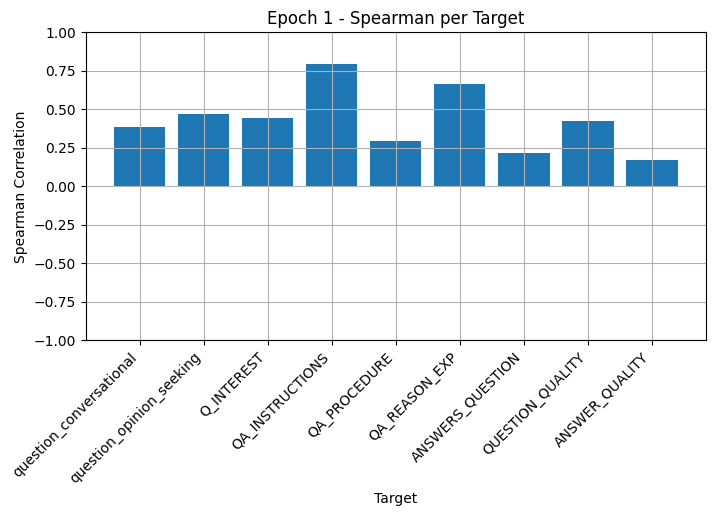


Epoch 2/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.79it/s]


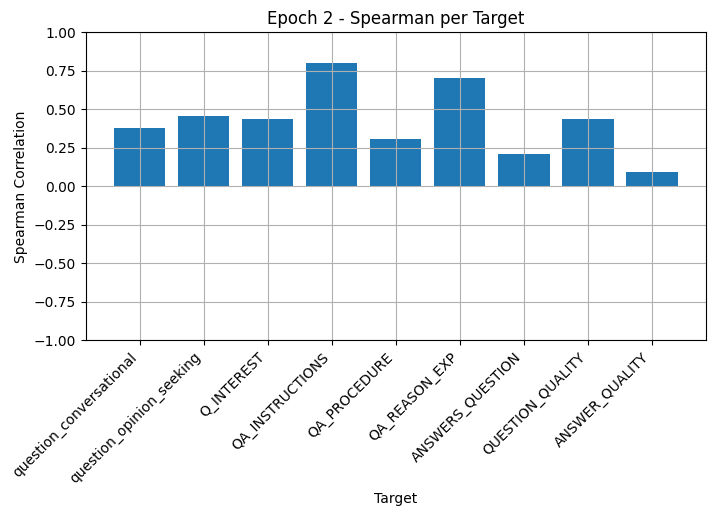


Epoch 3/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:39<00:00,  3.81it/s]


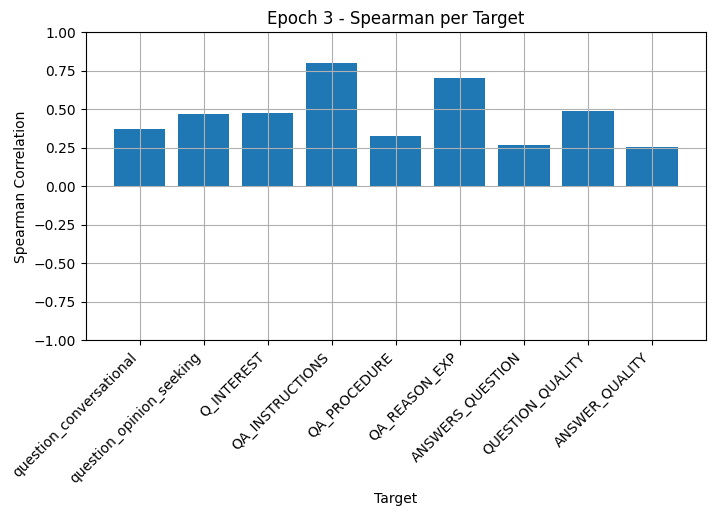


Epoch 4/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:39<00:00,  3.80it/s]


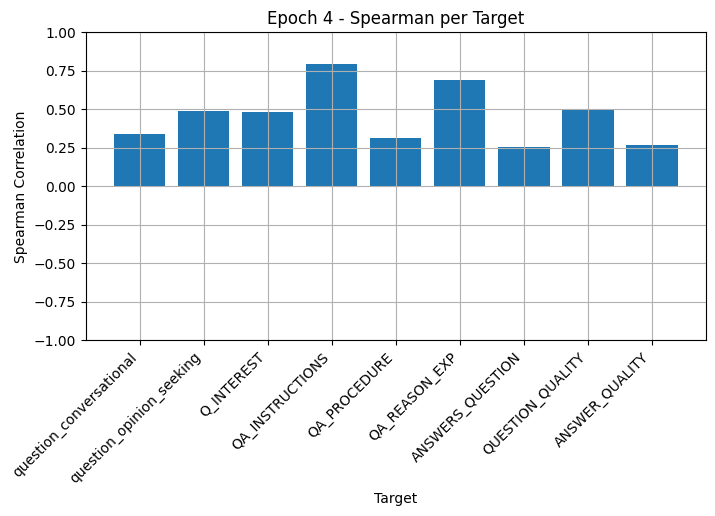


Epoch 5/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.78it/s]


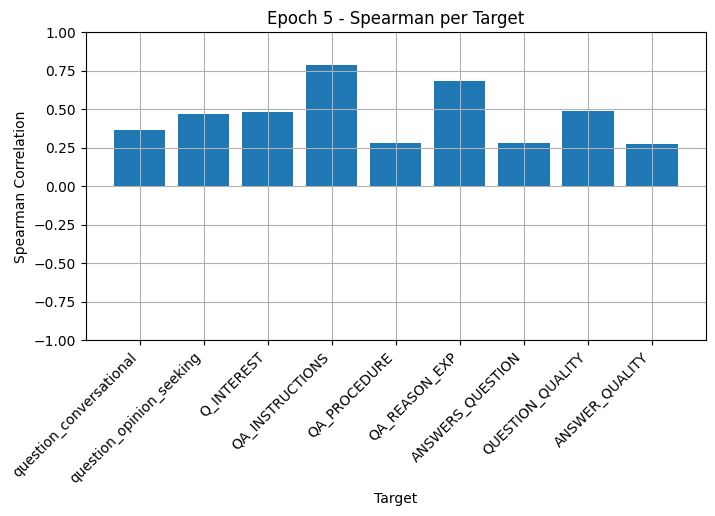


Epoch 6/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.79it/s]


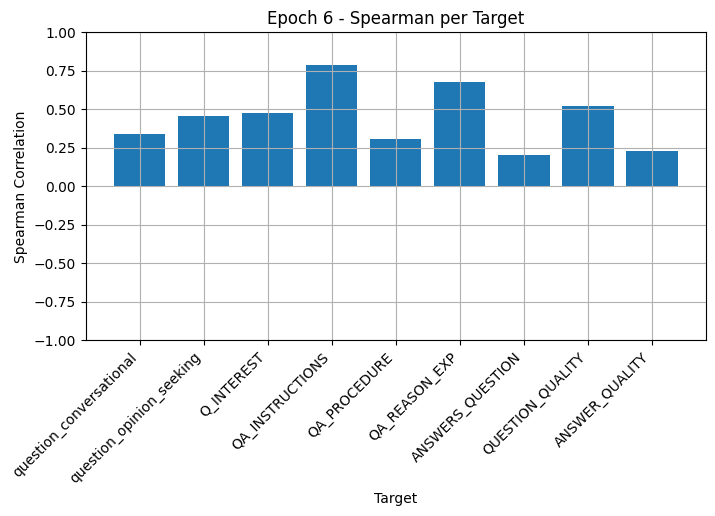


Epoch 7/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.77it/s]


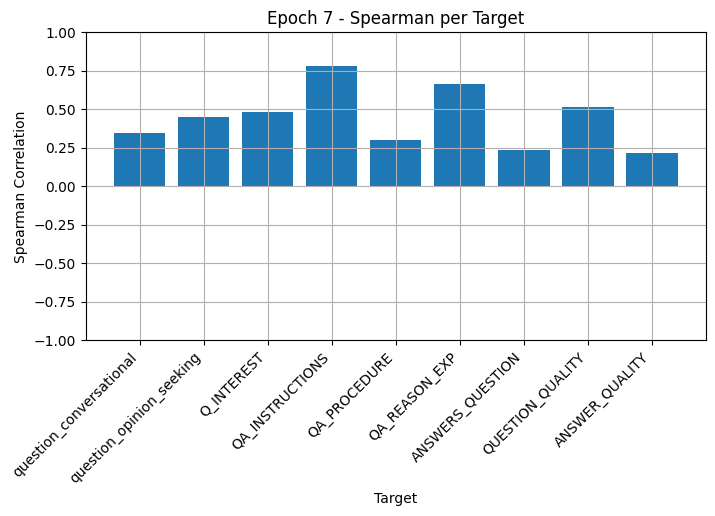


Epoch 8/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.77it/s]


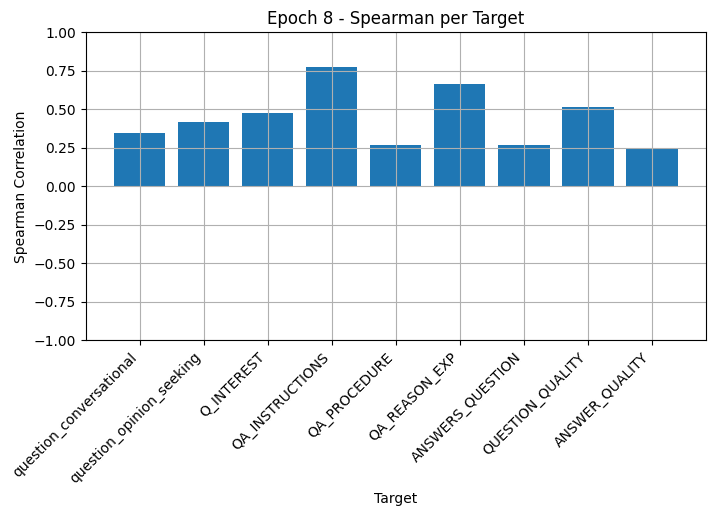


Epoch 9/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.75it/s]


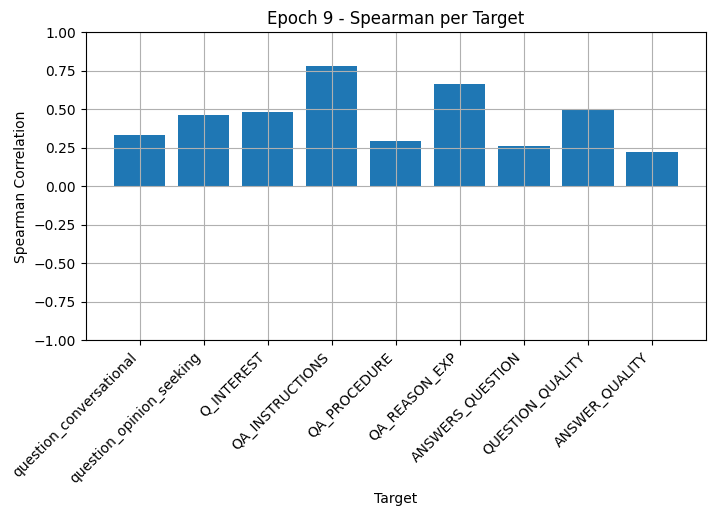


Epoch 10/10


  0%|          | 0/608 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
  0%|          | 0/152 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████| 152/152 [00:40<00:00,  3.74it/s]


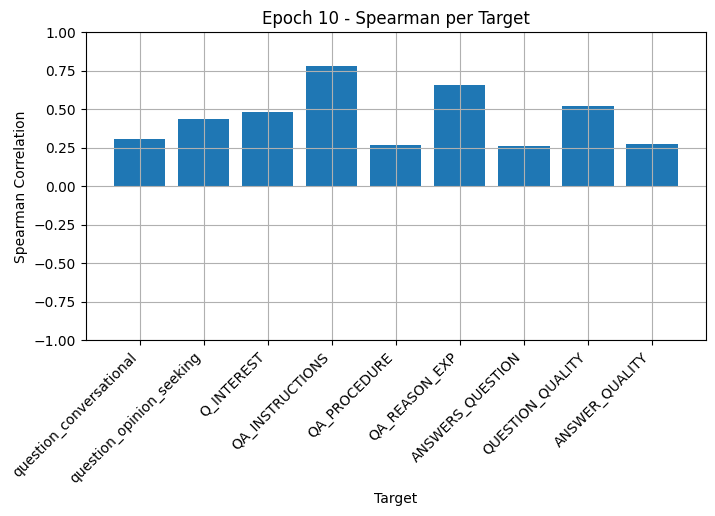

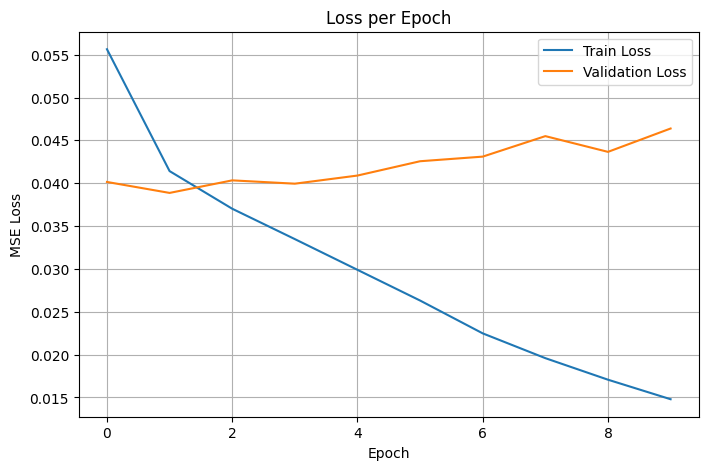

In [26]:
import torch
import torch.nn.functional as F
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseRobertaSharedCLS(
    model_name='roberta-base',
    num_targets=len(target_columns),  # usually 9
    use_cross_attention=True,
    use_single_cross=True  # or False to use both directions
).to(device)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
num_epochs = 10

train_model(model, train_loader, val_loader, optimizer, device, num_epochs)


In [27]:
torch.save(model.state_dict(), f"siamese_CrossAttention_roberta_epoch10.pth")

Attention in model:

**query:**

	Sequence whose tokens attend to key/value,	Query hidden states (e.g., question)

**key:**

	Sequence to attend over (to compute attention weights),	Key hidden states (e.g., answer)

**value	:**

  Sequence providing the vectors to combine via attention weights,	Same as key hidden states

**key_padding_mask:**

	Mask marking which tokens in key/value to ignore,	Inverted key_mask marking padded tokens


#inference

In [31]:
model = SiameseRobertaSharedCLS(num_targets=9, use_cross_attention=True, use_single_cross=True)

model.load_state_dict(torch.load('/content/siamese_CrossAttention_roberta_epoch10.pth', map_location=device))
model.to(device)
model.eval()


def predict(model, question_title, question_body, answer):
    model.eval()
    with torch.no_grad():
        q_text = "Title: " + question_title + " [SEP] " + question_body
        a_text = answer

        q_tokens = tokenizer(q_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
        a_tokens = tokenizer(a_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

        q_ids = q_tokens["input_ids"].to(device)
        q_mask = q_tokens["attention_mask"].to(device)
        a_ids = a_tokens["input_ids"].to(device)
        a_mask = a_tokens["attention_mask"].to(device)

        pred = model(q_ids, q_mask, a_ids, a_mask)
        return pred.squeeze(0).cpu().numpy()  # shape: (30,)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
def plot_predictions(preds, title):
    plt.figure(figsize=(14, 6))  # Taller plot (was 14x4)
    bars = plt.bar(target_columns, preds, color='skyblue')
    plt.xticks(rotation=90)
    plt.ylim(0, 1.1)  # Allow space above bars for text
    plt.ylabel("Predicted Score")
    plt.title(title)
    plt.grid(True, axis='y')

    # Add value labels on top of bars
    for bar, score in zip(bars, preds):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                 f'{score:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


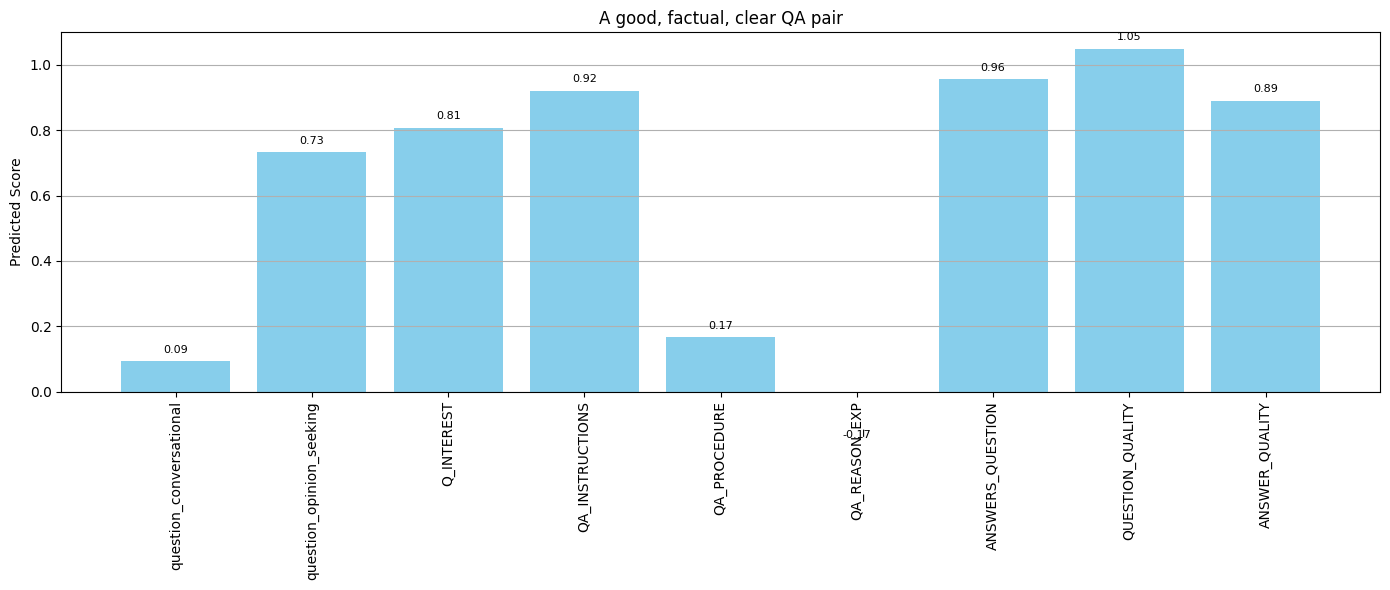

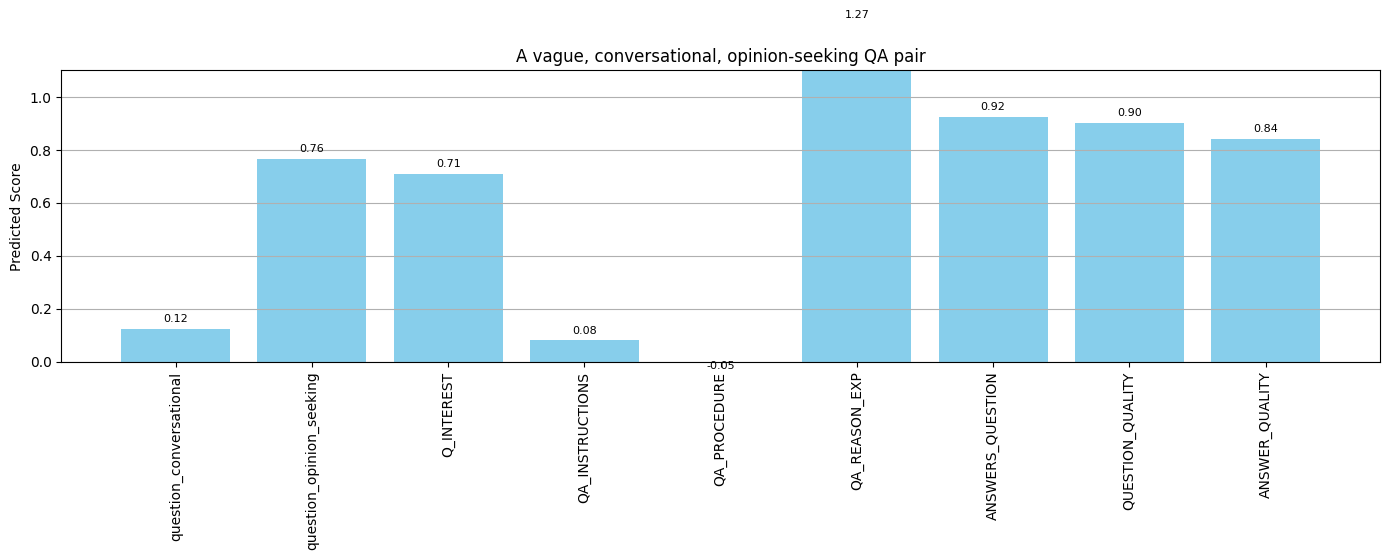

In [34]:

# A good, factual, clear QA pair
qa_first = {
    "question_title": "How can I clean a burnt stainless steel pot?",
    "question_body": "I've accidentally burnt food in my stainless steel pot. What are the most effective and safe methods to clean it without damaging the pot?",
    "answer": "Fill the pot with water and add a few tablespoons of baking soda. Bring it to a boil, let it cool, then scrub with a non-abrasive sponge. For stubborn stains, white vinegar can help."
}

# A vague, conversational, opinion-seeking QA pair
qa_contrast = {
    "question_title": "Why do some people hate cooking?",
    "question_body": "I was talking with my roommate and he said he hates cooking. I don’t get it. I love it. Why do people feel so differently?",
    "answer": "Well, everyone is different. Some people just don’t enjoy the process or find it stressful. Others might just not have learned how to cook well or associate it with chores."
}
pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)


plot_predictions(pred_first, "A good, factual, clear QA pair")
plot_predictions(pred_contrast, "A vague, conversational, opinion-seeking QA pair")


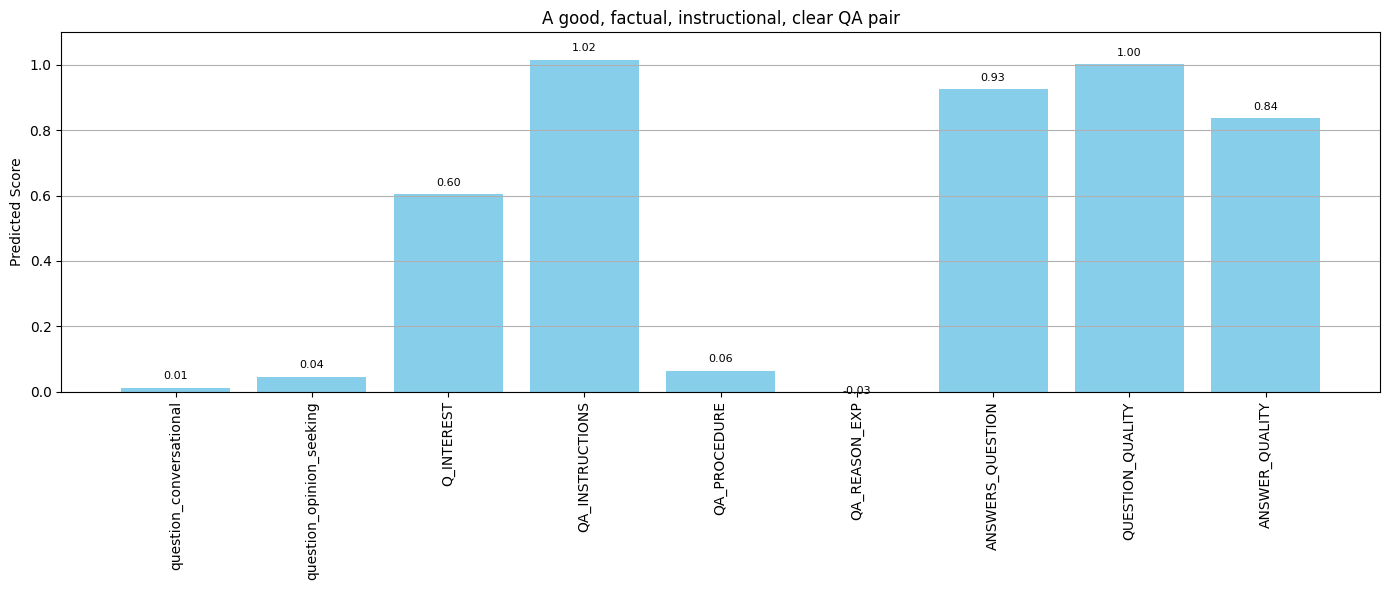

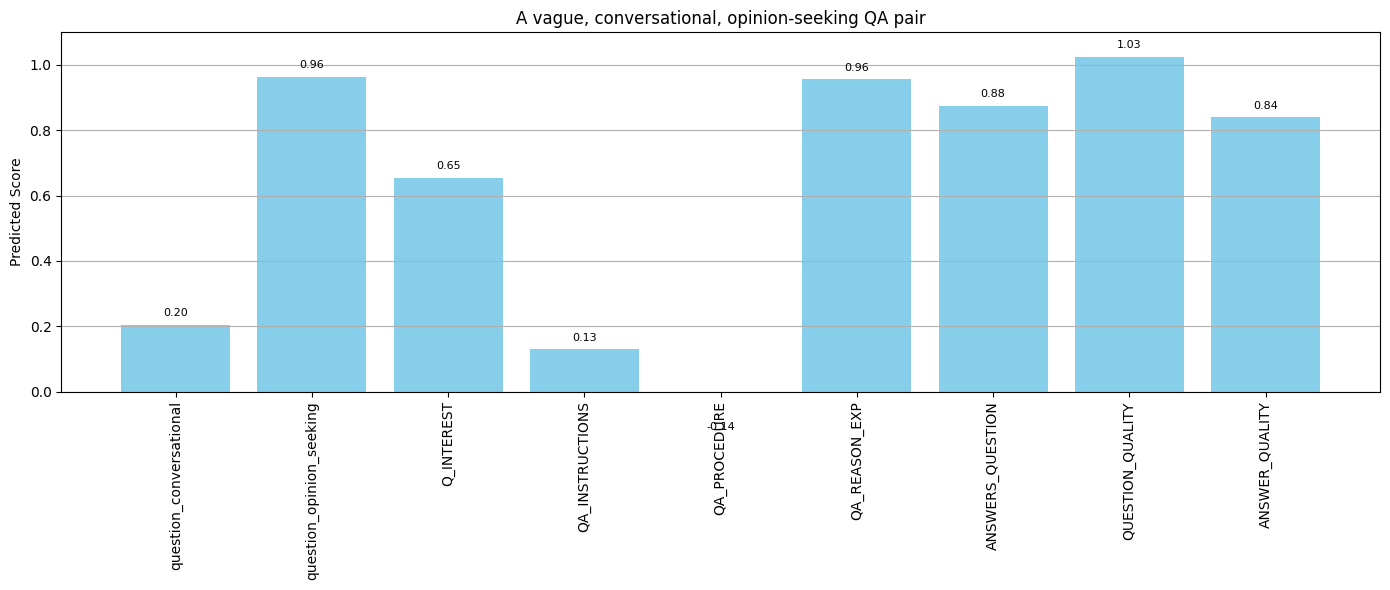

In [35]:
qa_first = {
    "question_title": "How can I reverse a list in Python?",
    "question_body": "I have a list of integers in Python and I want to reverse the order of elements. What's the most Pythonic way to do it?",
    "answer": "You can reverse a list in Python using slicing: `reversed_list = my_list[::-1]`. Alternatively, you can use the built-in `reversed()` function: `list(reversed(my_list))`. Both are commonly used."
}
qa_contrast = {
    "question_title": "Why is Python bad?",
    "question_body": "I’ve heard people say Python is not good for real devs. Is that true?",
    "answer": "I think Java is way better than Python anyway. Everyone should just switch to Java.",
}


pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)

plot_predictions(pred_first, "A good, factual, instructional, clear QA pair")
plot_predictions(pred_contrast, "A vague, conversational, opinion-seeking QA pair")

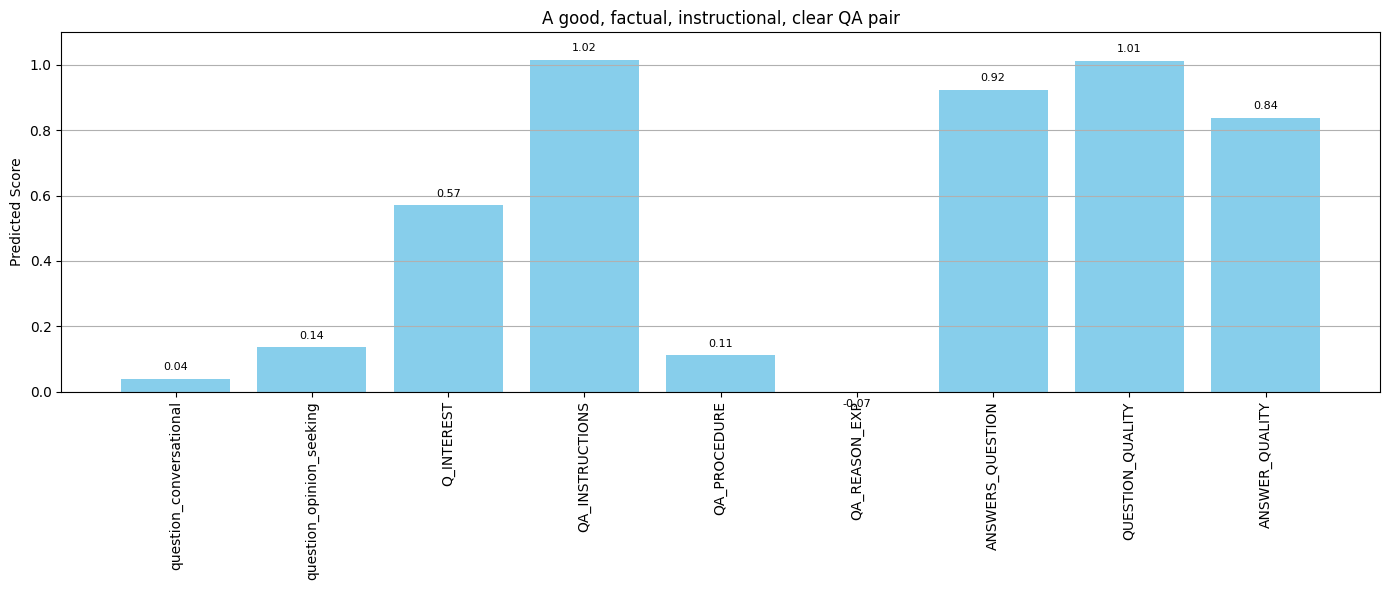

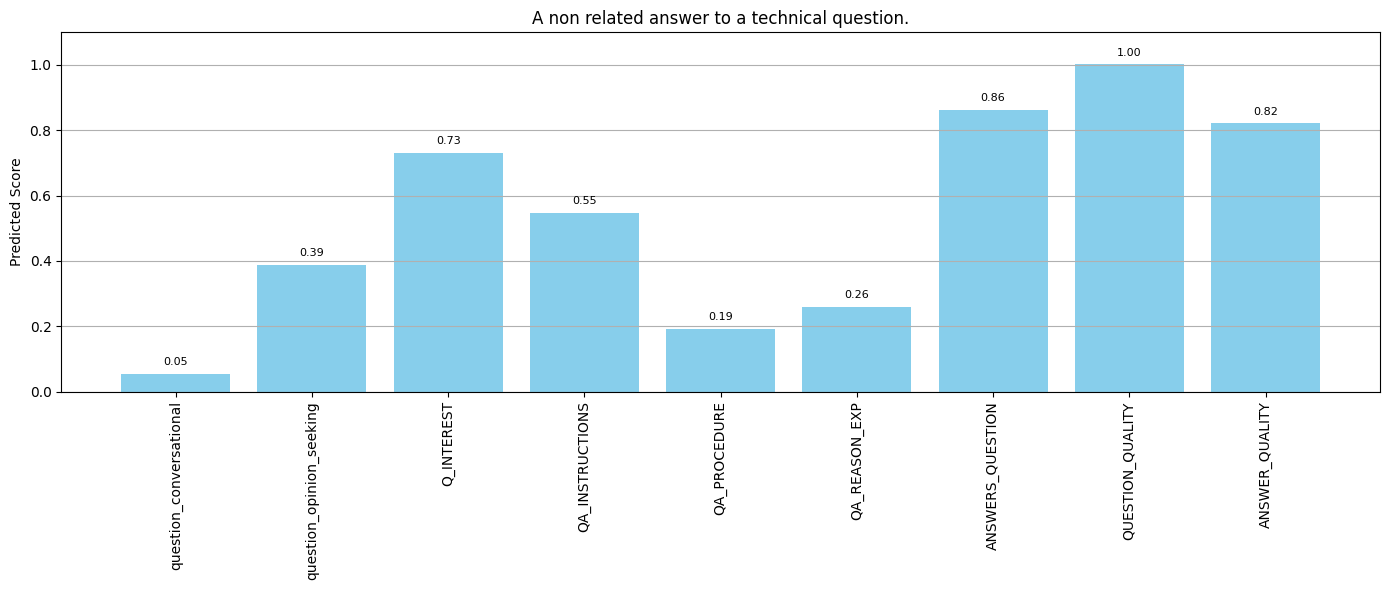

In [36]:
qa_first = {
    "question_title": "How to convert a list of integers to a comma-separated string in Python?",
    "question_body": "I have a list like `[1, 2, 3, 4]` and I want to convert it to the string `'1,2,3,4'`. What's the cleanest way to do this in Python?",
    "answer": "You can use the `join` method with a generator expression: `','.join(str(i) for i in [1, 2, 3, 4])`. This will give you the output `'1,2,3,4'`."
}
qa_contrast = {
    "question_title": "How to convert a list of integers to a comma-separated string in Python?",
    "question_body": "I have a list like `[1, 2, 3, 4]` and I want to convert it to the string `'1,2,3,4'`. What's the cleanest way to do this in Python?",
    "answer": "The habits of penguins are fascinating. In cold climates, they huddle together to stay warm and often take turns being on the outside of the group."
}


pred_first = predict(model, **qa_first)
pred_contrast = predict(model, **qa_contrast)

plot_predictions(pred_first, "A good, factual, instructional, clear QA pair")
plot_predictions(pred_contrast, "A non related answer to a technical question.")